In [29]:
#!/usr/bin/env python
##############################################################################
#
# diffpy.pdfmorph   by DANSE Diffraction group
#                   Simon J. L. Billinge
#                   (c) 2008 Trustees of the Columbia University
#                   in the City of New York.  All rights reserved.
#
# File coded by:    Chris Farrow
#
# See AUTHORS.txt for a list of people who contributed.
# See LICENSE.txt for license information.
#
##############################################################################
"""Collection of plotting functions for PDFs."""

import matplotlib.pyplot as plt
import numpy

# FIXME - make this return the figure object in the future, so several views
# can be composed.
def plotPDFs(pairlist, labels=None, offset ='auto', rmin = None, rmax = None):
    """Plots several PDFs on top of one another.
    pairlist    --  iterable of (r, gr) pairs to plot
    labels      --  iterable of names for the pairs. If this is not the same
                    length as the pairlist, a legend will not be shown (default
                    []).
    offset      --  offset to place between plots. PDFs will be sequentially
                    shifted in the y-direction by the offset. If offset is
                    'auto' (default), the optimal offset will be determined
                    automatically.
    rmin        --  The minimum r-value to plot. If this is None (default), the
                    lower bound of the PDF is not altered.
    rmax        --  The maximum r-value to plot. If this is None (default), the
                    upper bound of the PDF is not altered.
    """
    if labels is None:
        labels = []
    if offset is 'auto':
        offset = _findOffset(pairlist)

    gap = len(pairlist) - len(labels)
    labels = list(labels)
    labels.extend([""] * gap)

    for idx, pair in enumerate(pairlist):
        r, gr = pair
        plt.plot(r, gr + idx * offset, label = labels[idx])
    plt.xlim(rmin, rmax)

    if gap == 0:
        plt.legend(loc = 0)

    plt.xlabel("$r \mathrm{\AA}$")
    plt.ylabel("$G \mathrm{\AA}^{-1}$")

    plt.show()
    return

def comparePDFs(pairlist, labels=None, rmin = None, rmax = None, show = True,
                maglim = None, mag = 5, rw = None, legend = True):
    """Plot two PDFs on top of each other and difference curve.
    pairlist    --  iterable of (r, gr) pairs to plot
    labels      --  iterable of names for the pairs. If this is not the same
                    length as the pairlist, a legend will not be shown (default
                    []).
    rmin        --  The minimum r-value to plot. If this is None (default), the
                    lower bound of the PDF is not altered.
    rmax        --  The maximum r-value to plot. If this is None (default), the
                    upper bound of the PDF is not altered.
    show        --  Show the plot (True)
    maglim      --  Point after which to magnify the signal by mag. If None
                    (default), no magnification will take place.
    mag         --  Magnification factor (default 5)
    rw          --  Rw value to display on the plot, if any.
    legend      --  Display the legend (default True).
    The second PDF will be shown as blue circles below and the first as a red
    line.  The difference curve will be in green and offset for clarity.
    
    """
    if labels is None:
        labels = [2]
        labeldata = None
        labelfit = None
    else:
        labeldata = labels[1]
        labelfit = labels[0]
    rfit, grfit = pairlist[0]
    rdat, grdat = pairlist[1]

    # View min and max
    rvmin = max(rfit[0], rdat[0])
    rvmin = rmin or rvmin
    rvmax = min(rfit[-1], rdat[-1])
    rvmax = rmax or rfit[-1]

    gap = 2 - len(labels)
    labels = list(labels)
    labels.extend([""] * gap)

    # Put gr1 on the same grid as rdat
    gtemp = numpy.interp(rdat, rfit, grfit)

    # Calculate the difference
    diff = grdat - gtemp

    # Put rw in the label
    labeldiff = "difference" if len(labels) < 3 else labels[2]
    if rw is not None:
        labeldiff += " (Rw = %.3f)"%rw

    # Magnify if necessary
    if maglim is not None:
        grfit = grfit.copy()
        grfit[rfit > maglim] *= mag
        sel = rdat > maglim
        grdat = grdat.copy()
        grdat[sel] *= mag
        diff[sel] *= mag
        gtemp[sel] *= mag

    # Determine the offset for the difference curve.
    sel = numpy.logical_and( rdat <= rvmax, rdat >= rvmin)
    ymin = min(min(grdat[sel]), min(gtemp[sel]))
    ymax = max(diff[sel])
    offset = -1.1*(ymax - ymin)

    # Set up the plot
    _configure()

    # Scale the x-limit based on the r-extent of the signal. This gives a nice
    # density of PDF peaks.
    rlim = rvmax - rvmin
    scale = rlim / 25.0
    # Set a reasonable minimum of .8 and maximum of 1
    scale = min(1, max(scale, 0.8))
    figsize = [13.5, 4.5]
    figsize[0] *=  scale
    fig = plt.figure(1, figsize = figsize)
    # Get the margins based on the figure size
    lm = 0.12 / scale
    bm = 0.20 / scale
    rm = 0.02 / scale
    tm = 0.15 / scale
    axes = plt.Axes(fig, [lm, bm, 1 - lm - rm, 1 - bm - tm])
    fig.add_axes(axes)
    plt.minorticks_on()

    plt.plot(rdat, grdat, label = labeldata, marker = 'o', markerfacecolor
            = 'white', markeredgecolor = 'blue', markersize = 7,
            markeredgewidth = 0.75)
    plt.plot(rfit, grfit, label = labelfit, linestyle = 'solid', linewidth =
            2, color = 'red')
    plt.plot(rdat, offset*numpy.ones_like(diff), linestyle = '--', linewidth
            = 1, color = 'black', dashes = (15, 15), aa = False)
    diff += offset
    plt.plot(rdat, diff, label = labeldiff, linestyle = 'solid',
            linewidth = 1.5, color = 'green')

    if maglim is not None:
        # Add a line for the magnification cutoff
        plt.axvline(maglim, 0, 1, linestyle = '--', color = 'black',
                linewidth = 1.5, dashes = (14, 7))
        # FIXME - look for a place to put the maglim
        xpos = (rvmax*0.85 + maglim) / 2 / (rvmax - rvmin)
        if xpos <= 0.9:
            plt.figtext(xpos, 0.7, "x%.1f"%mag, backgroundcolor='w')

    # Get a tight view
    plt.xlim(rvmin, rvmax)
    ymin = min(diff[sel])
    ymax = max(max(grdat[sel]), max(gtemp[sel]))
    yspan = ymax - ymin
    # Give a small border to the plot
    gap = 0.05 * yspan
    ymin -= gap
    ymax += gap
    plt.ylim(ymin, ymax)

    # Make labels and legends
    plt.xlabel("r $\mathrm{\AA}$")
    plt.ylabel("G $(\mathrm{\AA}^{-1})$")
    if legend:
        plt.legend(bbox_to_anchor=(0.005, 1.02, 0.99, .10), loc=3,
                ncol=3, mode="expand", borderaxespad=0)
    if show: plt.show()

    return

def truncatePDFs(r, gr, rmin = None, rmax = None):
    """Truncate a PDF to specified bounds.
    r           --  r-values of the PDF
    gr          --  PDF values.
    rmin        --  The minimum r-value. If this is None (default), the lower
                    bound of the PDF is not altered.
    rmax        --  The maximum r-value. If this is None (default), the upper
                    bound of the PDF is not altered.
    Returns the truncated r, gr
    """

    if rmin is not None:
        sel = r >= rmin
        gr = gr[sel]
        r = r[sel]
    if rmax is not None:
        sel = r <= rmax
        gr = gr[sel]
        r = r[sel]

    return r, gr

def _configure():
    """Configure look and feel."""
    import matplotlib.pyplot as plt
    plt.rc("font", size = 40)
    plt.rc("axes", linewidth = 2, labelsize = 30)
    plt.rc("xtick", labelsize = 25)
    plt.rc("xtick.major", size = 7)
    plt.rc("xtick.minor", size = 3)
    plt.rc("ytick", labelsize = 25)
    plt.rc("ytick.major", size = 7)
    plt.rc("ytick.minor", size = 3)
    plt.rc("legend", fontsize = 18)
    plt.rc("lines", markeredgewidth = 2) # thicker axes and symbols
    return

def _findOffset(pairlist):
    """Find an optimal offset between PDFs."""
    maxlist = [max(p[1]) for p in pairlist]
    minlist = [min(p[1]) for p in pairlist]
    difflist = numpy.subtract(maxlist[:-1], minlist[1:])
    offset = 1.1 * max(difflist)
    return offset


In [30]:
import numpy as np
source_file = "//Users//matthew//dev//diffpy.pdfmorph//tests//testdata//ni_qmax25.cgr"

source_pairs = np.genfromtxt(source_file)

In [31]:
correct_array = []
for i in range(len(source_pairs)-1):
    correct_array.append([source_pairs[i+1],source_pairs[i]])
    i+=1

In [32]:
source_pairs.shape

(4000, 2)

In [33]:
r, gr = source_pairs[:, 0], source_pairs[:, 1]

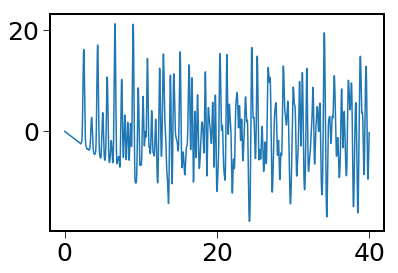

In [34]:
plt.plot(r, gr)

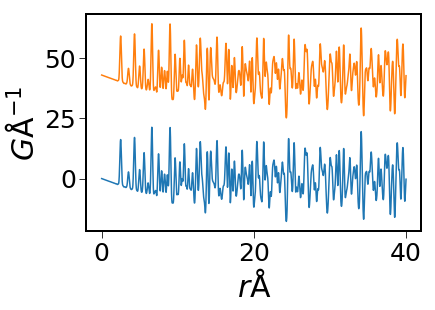

In [35]:
plotPDFs([(r,gr), (r, gr)])

In [36]:
len(correct_array)

3999

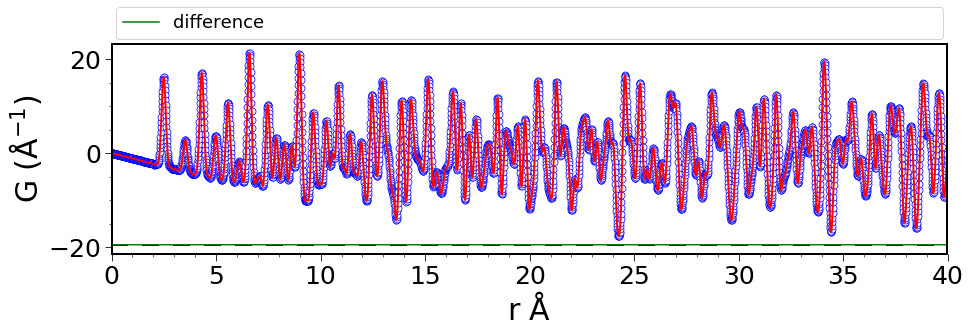

In [37]:
comparePDFs([(r,gr), (r, gr)])